# Importing Libraries and Setting Up the Environment

In [1]:
# Core libraries
import os
import sys
import timeit
import warnings
import numpy as np
import pandas as pd

# Audio processing
!pip install librosa==0.9.2 --quiet
import librosa
import librosa.display
print(librosa.__version__)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Audio playback
import IPython.display as ipd
from IPython.display import Audio

# Progress bar
import timeit
from tqdm import tqdm

# Preprocessing & evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Deep Learning - Keras & TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Activation, Embedding, LSTM, GRU, BatchNormalization,
    Conv1D, MaxPooling1D, AveragePooling1D, Input,
    LayerNormalization, MultiHeadAttention, Add
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.3 MB/s eta 0:00:00
0.9.2
TensorFlow version: 2.18.0


This cell sets up all necessary libraries for the project:

- **Core tools:** `numpy`, `pandas`, `os`, `sys`, `warnings`
- **Audio processing:** `librosa` (v0.9.2 for compatibility), `IPython.display` for audio playback
- **Visualization:** `matplotlib`, `seaborn`
- **Machine Learning:** `scikit-learn` for preprocessing and evaluation
- **Deep Learning:** `tensorflow.keras` for model building (Dense, LSTM, GRU, CNN layers, etc.)
- **Utilities:** `tqdm` for progress bars, `timeit` for timing

It also prints the versions of `librosa` and `TensorFlow` to confirm correct setup.


# Mount Google Drive and Load Dataset Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths for input Data
speech_dir = '/content/drive/MyDrive/Colab Notebooks/Audio_Speech_Actors_01-24'
song_dir = '/content/drive/MyDrive/Colab Notebooks/Audio_Song_Actors_01-24'
speech_directory_list = os.listdir(speech_dir)
song_directory_list = os.listdir(song_dir)
print(speech_directory_list)
print(song_directory_list)

['Actor_22', 'Actor_23', 'Actor_15', 'Actor_18', 'Actor_16', 'Actor_19', 'Actor_21', 'Actor_20', 'Actor_17', 'Actor_24', 'Actor_09', 'Actor_06', 'Actor_13', 'Actor_10', 'Actor_05', 'Actor_07', 'Actor_14', 'Actor_11', 'Actor_08', 'Actor_12', 'Actor_01', 'Actor_02', 'Actor_04', 'Actor_03']
['Actor_19', 'Actor_24', 'Actor_14', 'Actor_20', 'Actor_22', 'Actor_23', 'Actor_21', 'Actor_16', 'Actor_15', 'Actor_17', 'Actor_11', 'Actor_13', 'Actor_10', 'Actor_09', 'Actor_06', 'Actor_12', 'Actor_08', 'Actor_07', 'Actor_05', 'Actor_04', 'Actor_02', 'Actor_03', 'Actor_01']


- Mounts Google Drive to access the audio datasets stored in the user's Drive.
- Sets paths for:
  - `speech_dir`: Speech audio files
  - `song_dir`: Song audio files
- Lists and prints the directories inside both folders to verify successful access.

This confirms that the dataset folders (`Actor_01` to `Actor_24`) are correctly loaded from Drive.


# Extract File Paths and Emotion Labels from RAVDESS


In [4]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}


def get_emotion_from_filename(filename):
    # RAVDESS filenames are like: 03-01-06-01-02-01-12.wav
    # where the 3rd part (06) is the emotion
    parts = filename.split('-')
    emotion_code = parts[2]
    return emotion_dict.get(emotion_code)

def load_ravdess_dataset(directory):
    filepaths = []
    emotions = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                emotion = get_emotion_from_filename(file)
                path = os.path.join(root, file)
                filepaths.append(path)
                emotions.append(emotion)

    df = pd.DataFrame({'file_path': filepaths, 'emotion': emotions})
    return df

In [5]:
speech_df = load_ravdess_dataset(speech_dir)
song_df = load_ravdess_dataset(song_dir)
ravdess_df = pd.concat([speech_df, song_df], axis=0, ignore_index=True)
# speech_df
# song_df
ravdess_df

file_path  emotion
0     /content/drive/MyDrive/Colab Notebooks/Audio_S...     calm
1     /content/drive/MyDrive/Colab Notebooks/Audio_S...  neutral
2     /content/drive/MyDrive/Colab Notebooks/Audio_S...  neutral
3     /content/drive/MyDrive/Colab Notebooks/Audio_S...     calm
4     /content/drive/MyDrive/Colab Notebooks/Audio_S...     calm
...                                                 ...      ...
2447  /content/drive/MyDrive/Colab Notebooks/Audio_S...     fear
2448  /content/drive/MyDrive/Colab Notebooks/Audio_S...      sad
2449  /content/drive/MyDrive/Colab Notebooks/Audio_S...     fear
2450  /content/drive/MyDrive/Colab Notebooks/Audio_S...     fear
2451  /content/drive/MyDrive/Colab Notebooks/Audio_S...    happy

[2452 rows x 2 columns]

- Defines an `emotion_dict` to map emotion codes to labels (based on RAVDESS naming).
- Implements `get_emotion_from_filename()` to extract the emotion code from each filename.
- Implements `load_ravdess_dataset()` to:
  - Traverse through all `.wav` files in a directory
  - Extract file paths and corresponding emotion labels
- Loads both **speech** and **song** datasets.
- Combines them into a single `ravdess_df` dataframe containing:
  - `file_path`: full path to each audio file
  - `emotion`: its corresponding label

This dataframe will be used for further processing and model training.


**Checking for Missing Values**

In [6]:
# Check for missing values in all the dataframes
print("speech_dir nullCheck")
speech_nullCheck = speech_df.isnull().sum()
print(speech_nullCheck)
print("song_dir nullCheck")
song_nullCheck = song_df.isnull().sum()
print(song_nullCheck)

speech_dir nullCheck
file_path    0
emotion      0
dtype: int64
song_dir nullCheck
file_path    0
emotion      0
dtype: int64


This step ensures data integrity by verifying that there are no missing values in the loaded DataFrames.

- **`isnull().sum()`** is used to count the number of null entries in each column.
- It is applied to both `speech_df` and `song_df` separately.
- The output should show `0` for both `file_path` and `emotion` columns, confirming that all audio files have corresponding emotion labels and valid file paths.

Performing this check helps prevent unexpected issues during preprocessing and model training.


# Visualizing Emotion Distribution

In [7]:
# Function to plot the Bar Graph
def plot_emotion_counts(df, title):
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)

    # Add counts on top of each bar, formatted as integers
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.title(title)
    plt.xlabel('emotions')
    plt.ylabel('Count')
    plt.show()

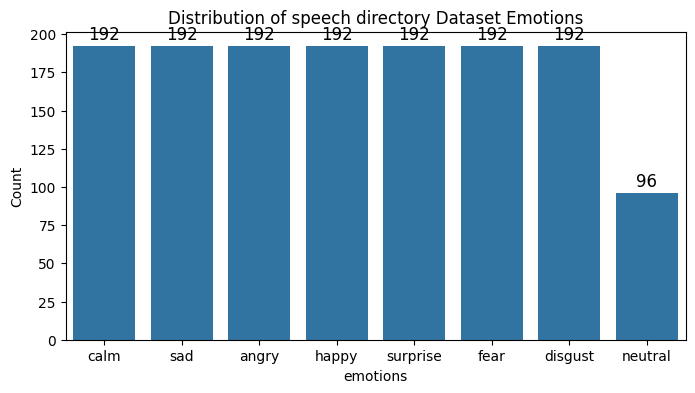

In [8]:
plot_emotion_counts(speech_df, 'Distribution of speech directory Dataset Emotions')

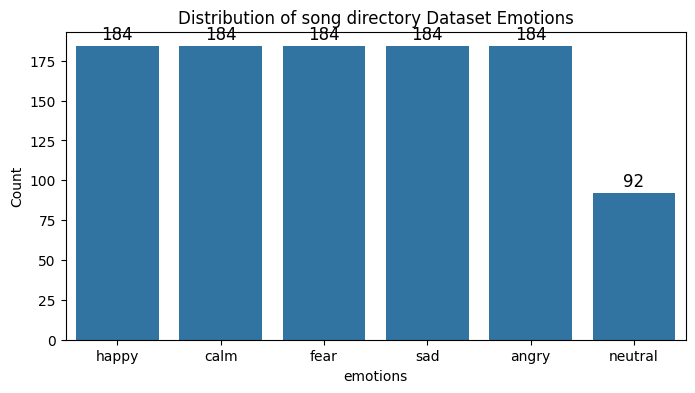

In [9]:
plot_emotion_counts(song_df, 'Distribution of song directory Dataset Emotions')

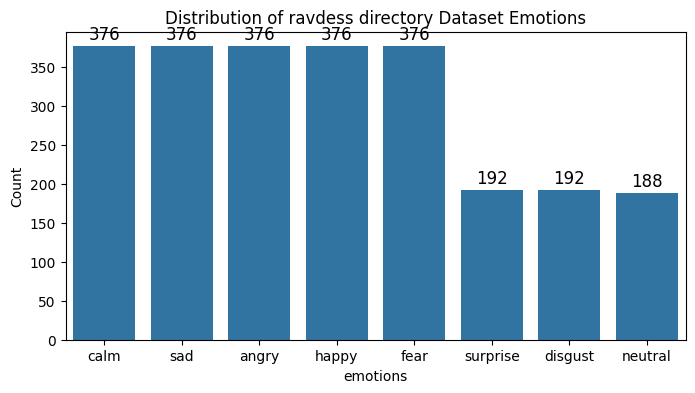

emotion
calm        376
sad         376
angry       376
happy       376
fear        376
surprise    192
disgust     192
neutral     188
Name: count, dtype: int64


In [10]:
plot_emotion_counts(ravdess_df, 'Distribution of ravdess directory Dataset Emotions')
print(ravdess_df.emotion.value_counts())

This step visualizes the distribution of emotion classes in the dataset to check for class imbalance.

- **`plot_emotion_counts()`**:
  - A custom function that plots a bar graph using `seaborn.countplot`.
  - Bars represent the number of audio samples per emotion.
  - Each bar is annotated with the corresponding count for better readability.

- **Usage:**
  - Plots are generated for:
    - `speech_df`: Emotion distribution in speech audio files.
    - `song_df`: Emotion distribution in song audio files.
    - `ravdess_df`: Combined dataset (speech + song).

- **`value_counts()`**: Displays exact counts for each emotion class in `ravdess_df`.

This analysis helps identify if the dataset is imbalanced, which can influence model performance and inform potential use of data augmentation or class weighting.


**Load a Sample Audio File**

In [11]:
# Load the first file
data, sr = librosa.load(ravdess_df['file_path'][0], sr=None)  # sr=None preserves original sampling rate
print("Sampling rate:", sr)


Sampling rate: 48000


Loads the first audio file from the dataset using `librosa`.

- `sr=None` preserves the original sampling rate.
- Prints the sampling rate to confirm successful loading.


# Define Waveform and Spectrogram Plot Functions


In [12]:
# Waveform plot function
def create_waveplot(data, sr, emotion_label):
    plt.figure(figsize=(10, 2))
    plt.title(f'Waveplot for audio with "{emotion_label}" emotion', fontsize=14)
    librosa.display.waveshow(data, sr=sr, color='steelblue')  # manually set color
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Spectrogram plot function
def create_spectrogram(data, sr, emotion_label):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with "{emotion_label}" emotion', fontsize=14)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


Defines two functions to visualize audio signals:

- **`create_waveplot()`**: Plots the waveform (amplitude vs. time).
- **`create_spectrogram()`**: Plots the spectrogram (frequency vs. time) in decibels.

These visualizations help understand the structure and intensity of different emotions in audio signals.


# Visualizing and Playing a 'Fear' Emotion Sample

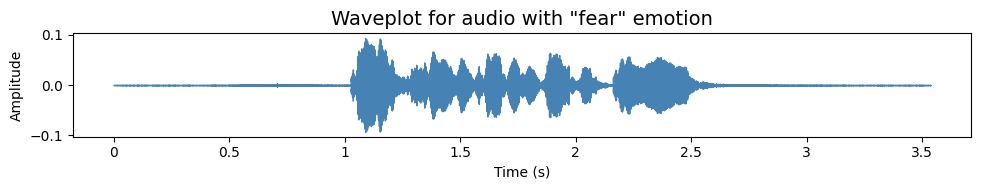

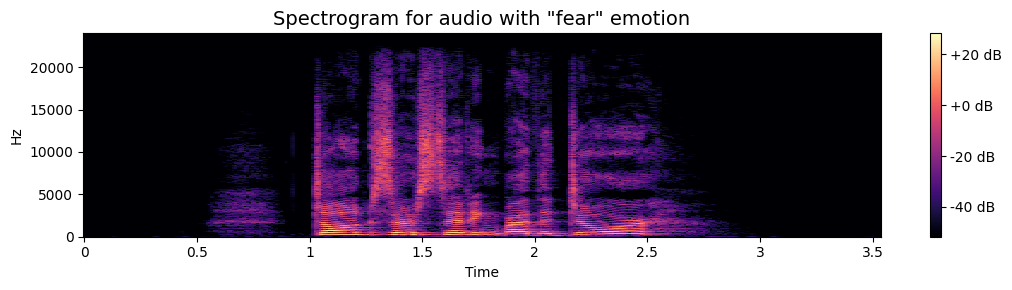

In [13]:
# Waveplot and Spectogram for the audio sample of 'Fear'
emotion = 'fear'

# Get the path of the second audio file (index 1) with that emotion
path = np.array(ravdess_df['file_path'][ravdess_df['emotion'] == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)  # sr=None keeps original sampling rate

# Plot waveform & spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


This step selects the second audio sample labeled as **'fear'** and:

- Loads the audio using `librosa.load()` with the original sampling rate.
- Visualizes the audio:
  - **Waveform**: Shows amplitude over time.
  - **Spectrogram**: Shows how frequencies change over time.
- Plays the audio using `IPython.display.Audio` for auditory inspection.

These visual tools help understand how the emotion "fear" is represented acoustically.


# Visualizing and Playing a 'Happy' Emotion Sample

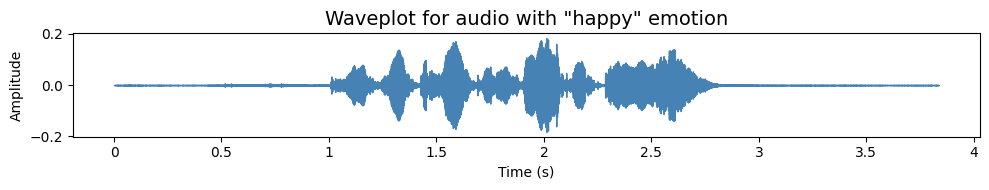

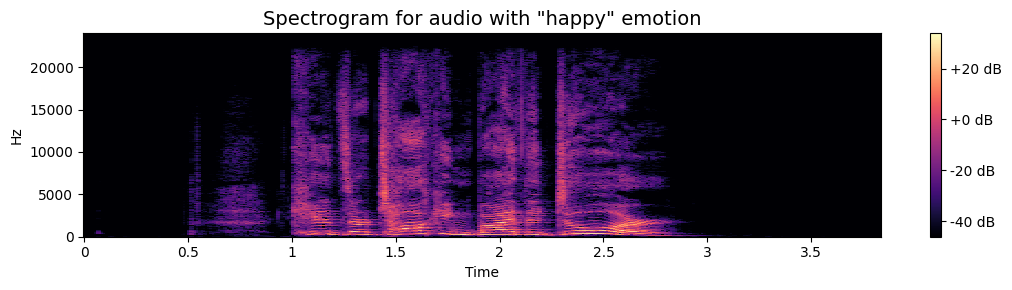

In [14]:
# Waveplot and Spectogram for the audio sample of 'happy'
emotion = 'happy'
path = np.array(ravdess_df['file_path'][ravdess_df['emotion'] == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

Loads and visualizes an audio sample labeled **'happy'**:

- Displays the **waveform** and **spectrogram** to analyze acoustic patterns.
- Plays the audio for listening.

This helps compare how different emotions, like "happy" vs. "fear", vary in both visual and auditory characteristics.


# Visualizing and Playing a 'Sad' Emotion Sample

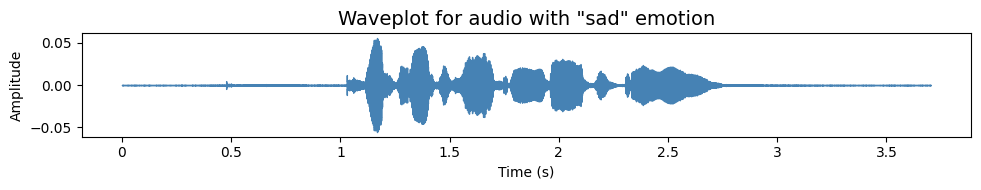

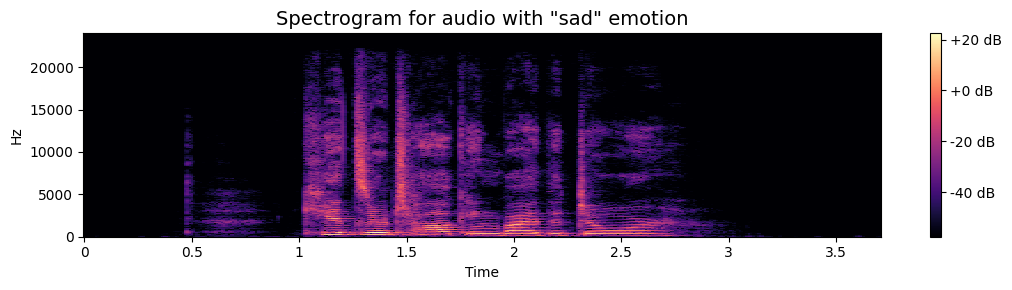

In [15]:
# Waveplot and Spectogram for the audio sample of 'sad'
emotion = 'sad'
path = np.array(ravdess_df['file_path'][ravdess_df['emotion'] == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

Loads an audio sample labeled **'sad'** and:

- Plots the **waveform** and **spectrogram** for visual inspection.
- Plays the audio to observe how "sad" emotion sounds.

This step helps in understanding the audio characteristics of different emotional states.


# Visualizing and Playing an 'Angry' Emotion Sample

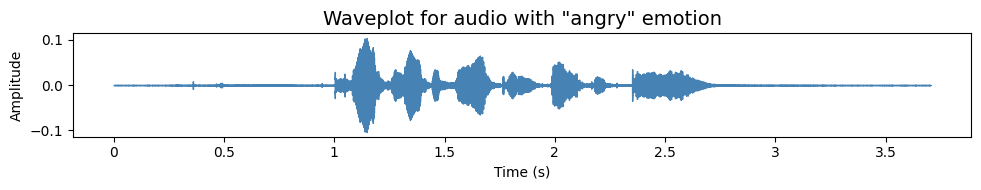

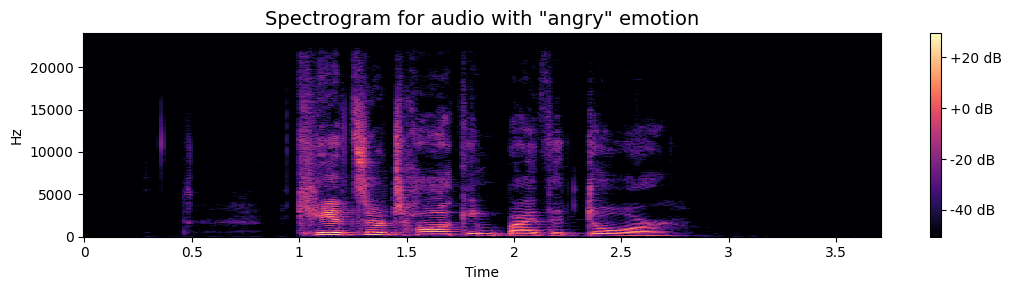

In [16]:
# Waveplot and Spectogram for the audio sample of 'angry'
emotion = 'angry'
path = np.array(ravdess_df['file_path'][ravdess_df['emotion'] == emotion])[1]

# Load the audio file
data, sampling_rate = librosa.load(path, sr=None)

# Create the waveplot and spectrogram
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)



This step loads and analyzes an audio file labeled **'angry'**:

- Plots the **waveform** and **spectrogram** to examine intensity and frequency patterns.
- Plays the audio to understand how anger is expressed vocally.

It supports comparing emotional tones across different categories.


**Checking Sampling Rate of Loaded Audio**

In [17]:
# Load the audio file
data, sr = librosa.load(path, sr=None)
sr

48000

Loads the selected audio file and prints its **sampling rate (`sr`)**.

This confirms the number of audio samples captured per second (e.g., 48000 Hz), which is important for consistent audio processing and feature extraction.


**Data Preprocessing**


# Trimming Silence from an 'Angry' Audio Sample

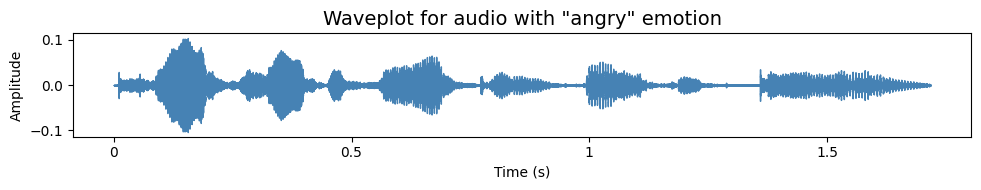

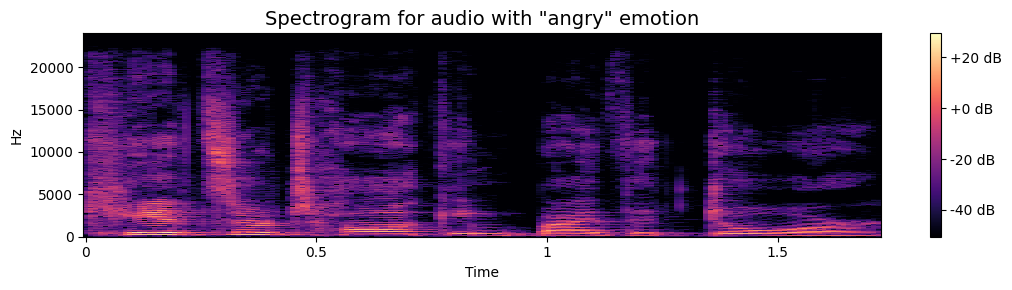

In [18]:
def trim_silence(y, top_db=30):
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed


# Waveplot and Spectogram for the audio sample of 'Happy'
emotion = 'angry'
path = np.array(ravdess_df['file_path'][ravdess_df['emotion'] == emotion])[1]

# Load the audio file
data, sr = librosa.load(path, sr=None)

data = trim_silence(data)

# Create the waveplot and spectrogram
create_waveplot(data, sr, emotion)
create_spectrogram(data, sr, emotion)

# Play the audio
Audio(path)



- **`trim_silence()`**: Removes low-energy silent sections from the audio using `librosa.effects.trim()` with a threshold of `top_db=30`.
- Reloads an **'angry'** audio sample, trims silence, and:
  - Plots the **waveform** and **spectrogram** after trimming.
  - Plays the original audio for reference.

Trimming helps reduce noise and focus on meaningful speech segments for better model performance.


**Reloading First Audio Sample to Confirm Sampling Rate**

In [19]:
file_path = ravdess_df['file_path'].values  # or: file_path = data_path.Path.values

# Load the first audio file
data, sr = librosa.load(file_path[0], sr=None)  # Use sr=None to keep original sampling rate
sr

48000

- Retrieves all audio file paths from the dataset.
- Loads the **first audio file** again using `librosa.load()` with `sr=None`.
- Prints the sampling rate to verify consistency across audio files.

Ensures the dataset maintains a uniform format for audio processing.


# Generating Log-Mel Spectrogram

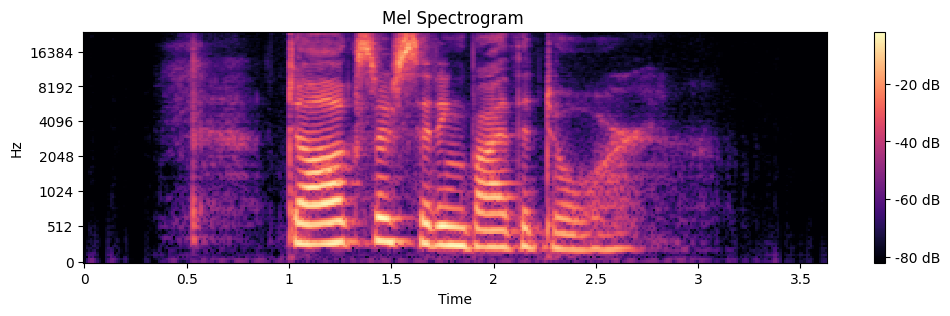

In [20]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(12, 3))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')



- Computes a **Mel spectrogram** using `librosa.feature.melspectrogram()` with:
  - 128 Mel bands
  - Max frequency capped at 8000 Hz
- Converts it to a **log scale** (decibels) for better visual interpretation using `librosa.power_to_db()`.
- Displays the spectrogram with `librosa.display.specshow()`.

The log-Mel spectrogram is a key input feature for many deep learning audio models.


**Playing an Audio File**

In [21]:
# Load audio file
data, sr = librosa.load(ravdess_df['file_path'].iloc[0], sr=None)

# Play it
ipd.Audio(data, rate=sr)



- Loads the first audio sample from the dataset using `librosa.load()`.
- Plays the audio using `IPython.display.Audio()` for direct listening in the notebook.

This helps verify the audio quality and listen to the raw input before preprocessing.


# Extracting and Visualizing MFCCs

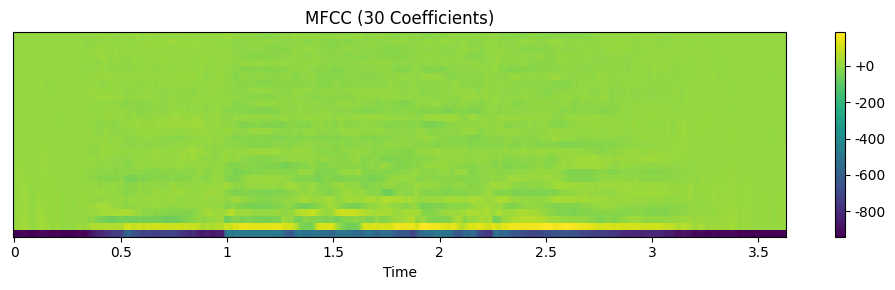

In [22]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

# Mel-Frequency Cepstral Coefficients mimics hwo human hear and process audio
plt.figure(figsize=(10, 3))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar(format="%+2.0f")
plt.title("MFCC (30 Coefficients)")
plt.tight_layout()
plt.show()

- Computes **MFCCs (Mel-Frequency Cepstral Coefficients)** using `librosa.feature.mfcc()` with 30 coefficients.
- MFCCs simulate how humans perceive sound and are widely used for audio-based classification tasks.
- Plots the MFCCs over time using a heatmap.

These features will later serve as input to the deep learning model.


# Data Augmentation

**Plotting and Playing the Original Waveform**

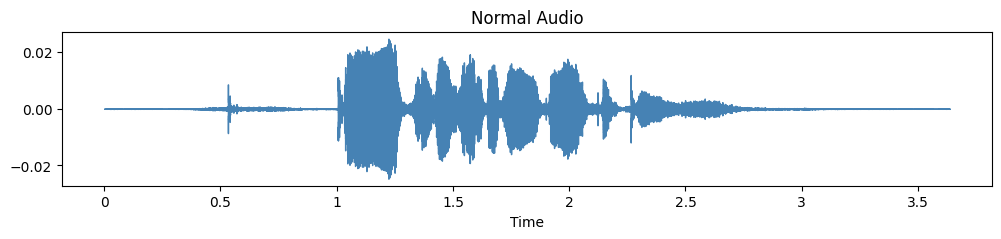

In [23]:
plt.figure(figsize=(12, 2))
plt.title('Normal Audio')
librosa.display.waveshow(y=data, sr=sr,color='steelblue')
plt.show()

ipd.Audio(data, rate=sr)


- Plots the **waveform** of the original audio signal using `librosa.display.waveshow()`.
- Plays the audio using `IPython.display.Audio()` for reference.

This gives a quick visual and auditory overview of the unprocessed audio sample.


**Noise Injection for Data Augmentation**

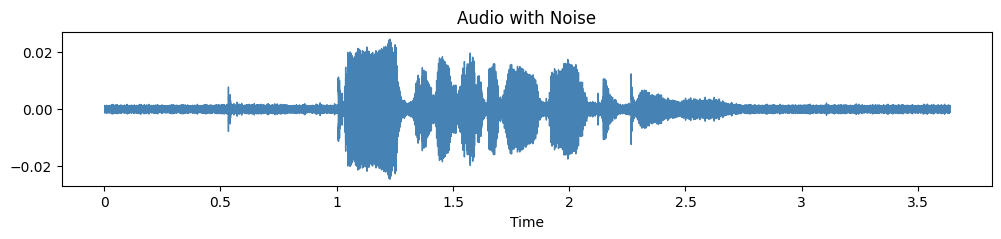

In [24]:
# Noise Injection
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Audio With Noise
x = noise(data)
plt.figure(figsize=(12,2))
plt.title('Audio with Noise')
librosa.display.waveshow(y=x, sr=sr,color='steelblue')
ipd.Audio(x, rate=sr)

- **`noise()`**: Adds random Gaussian noise to the audio signal to simulate real-world variability.
- Plots the **waveform of the noisy audio**.
- Plays the augmented audio for listening.

Noise injection helps improve model robustness by making it less sensitive to background sounds.


**Time-Stretching Audio for Augmentation**

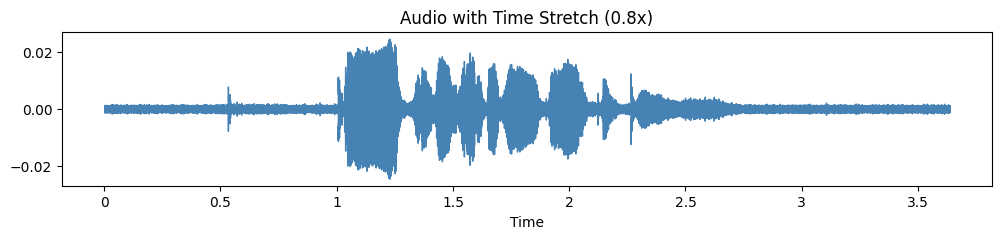

In [25]:
# Time Stretch
def stretch_audio(data, rate):
    return librosa.effects.time_stretch(data, rate)


# Apply time-stretch
if len(data.shape) > 1:
    data = librosa.to_mono(data)

# Apply time-stretch (correct usage)
stretched = librosa.effects.time_stretch(y=data, rate=0.8)

# Plot stretched waveform
plt.figure(figsize=(12, 2))
plt.title('Audio with Time Stretch (0.8x)')
librosa.display.waveshow(x, sr=sr,color='steelblue')
plt.show()

# Play stretched audio
ipd.Audio(stretched, rate=sr)


- **`stretch_audio()`**: Applies time-stretching using `librosa.effects.time_stretch()`.
- Slows down the audio by a factor of `0.8` (i.e., 80% of original speed).
- Plots the **waveform** of the time-stretched audio.
- Plays the stretched version for auditory validation.

Time-stretching helps the model generalize better by introducing tempo variation without altering pitch.


**Time Shifting for Audio Augmentation**

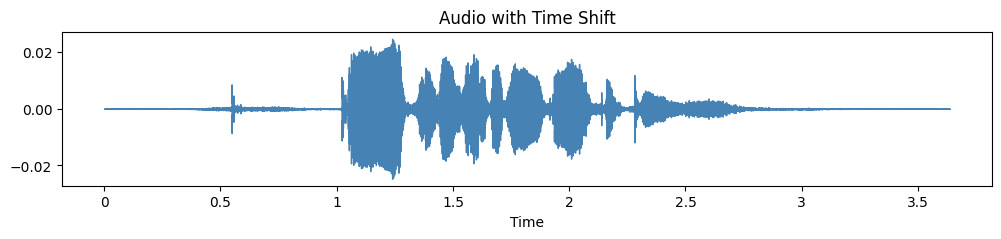

In [26]:
# Time Shifting
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

x = shift(data)
plt.figure(figsize=(12,2))
plt.title('Audio with Time Shift')
librosa.display.waveshow(y=x, sr=sr,color='steelblue')
ipd.Audio(x, rate=sr)



- **`shift()`**: Shifts the audio signal forward or backward by a random amount using `np.roll()`.
- Plots the **waveform** of the time-shifted audio.
- Plays the shifted audio to observe the effect.

Time shifting adds temporal variation and helps the model become less sensitive to timing differences in speech.


**Pitch Shifting for Audio Augmentation**

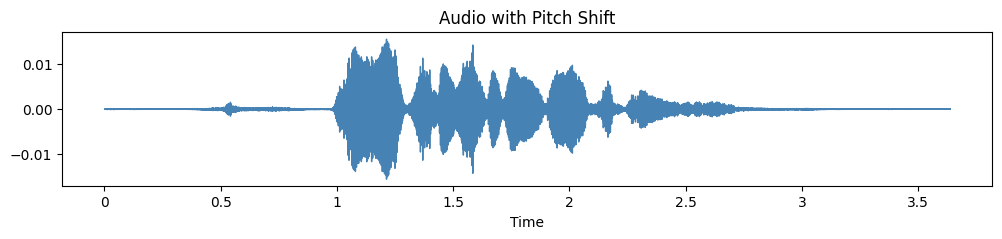

In [27]:
# Pitch Shifting
def pitch_shift_audio(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

x = pitch_shift_audio(data, sr, pitch_factor=0.7)
plt.figure(figsize=(12, 2))
plt.title('Audio with Pitch Shift')
librosa.display.waveshow(y=x, sr=sr,color='steelblue')
ipd.Audio(x, rate=sr)

- **`pitch_shift_audio()`**: Shifts the pitch of the audio using `librosa.effects.pitch_shift()`.
  - `pitch_factor=0.7` increases the pitch slightly without changing duration.
- Plots the **waveform** of the pitch-shifted audio.
- Plays the modified audio to hear the pitch change.

Pitch shifting introduces vocal tone variations and improves the model’s ability to generalize across different speakers.


# Feature Extraction

**Feature Extraction with Augmentation**

In [28]:
# ZCR, to identify emotions that involve rapid changes in sound
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)


# RMSE, to measure the intensity of the speech signal
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


# MFCC, to capture the speech features most relevant to human perception
def extract_mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feat = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30,
                                     hop_length=hop_length, n_fft=frame_length)
    return np.squeeze(mfcc_feat.T) if not flatten else np.ravel(mfcc_feat.T)

# Feature extractor
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    result = np.hstack((
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        extract_mfcc(data, sr, frame_length, hop_length)
    ))
    return result

# Main function with augmentations
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)

    # Original
    aud=extract_features(data)
    audio=np.array(aud)

    # Augmentations
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch_shift_audio(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch_shift_audio(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio


Defines functions to extract key audio features and apply data augmentation:

- **ZCR (Zero Crossing Rate):** Detects rapid signal changes — useful for identifying emotions with sharp transitions.
- **RMSE (Root Mean Square Energy):** Measures signal intensity to capture loudness.
- **MFCC (Mel-Frequency Cepstral Coefficients):** Extracts features that mimic human auditory perception.

 `extract_features()`
Combines ZCR, RMSE, and MFCCs into a single feature vector for each audio clip.

  `get_features()`
Performs feature extraction with augmentation:
- **Original audio**
- **Noised audio**
- **Pitch-shifted audio**
- **Pitch-shifted + noised audio**

Returns a stacked array of all feature variants for each input file, enhancing model robustness through data diversity.


**Extracting Features for Entire Dataset**

In [29]:
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(ravdess_df.file_path,ravdess_df.emotion,range(ravdess_df.file_path.shape[0]))):
    features=get_features(path,duration=2.5, offset=0.6)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  2.80it/s]

0 audio has been processed


501it [09:37,  1.04it/s]

500 audio has been processed


1001it [19:31,  1.01it/s]

1000 audio has been processed


1501it [29:02,  1.12s/it]

1500 audio has been processed


2001it [39:57,  1.26s/it]

2000 audio has been processed


2452it [49:42,  1.22s/it]

Done
Time:  2982.0149857720003


This loop extracts features from all audio files and applies augmentations:

- Iterates through each audio file and its emotion label.
- Uses `get_features()` to extract original + augmented features.
- Appends each feature vector to `X` and the corresponding label to `Y`.
- Logs progress every 500 files using `print()` and `tqdm` for a progress bar.
- Measures total processing time using `timeit`.

This step prepares the full feature set and labels needed for training the emotion classification model.


**Saving Extracted Features to CSV**


In [30]:
# Creating a csv file for further processing of data
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y

Emotions.to_csv('/content/drive/My Drive/FinalCSVs/Ravdessnew.csv', index=False)
print(Emotions.isna().any())
Emotions.head()

0           False
1           False
2           False
3           False
4           False
            ...  
3452         True
3453         True
3454         True
3455         True
Emotions    False
Length: 3457, dtype: bool


0         1         2         3         4         5         6  \
0  0.097656  0.146484  0.192383  0.187988  0.184082  0.181152  0.175781   
1  0.177734  0.263672  0.355957  0.354004  0.330566  0.332520  0.326172   
2  0.097656  0.143555  0.189453  0.180664  0.185547  0.182129  0.174805   
3  0.234863  0.349609  0.462402  0.449219  0.434570  0.431641  0.433594   
4  0.112793  0.163574  0.211426  0.208496  0.224609  0.279785  0.306641   

          7         8         9  ...      3447      3448      3449      3450  \
0  0.180664  0.205566  0.234863  ...  6.086042  0.873917 -3.228450 -6.535547   
1  0.359375  0.401855  0.427734  ...  4.514407  4.683082  0.385546 -1.302032   
2  0.173828  0.166016  0.166992  ... -0.985729 -6.295506 -3.088084 -3.702894   
3  0.459473  0.479980  0.479492  ... -4.191974  1.319093 -0.651345  1.602668   
4  0.394531  0.505371  0.594727  ...  1.106141  0.042642 -1.219911 -2.269003   

       3451      3452      3453      3454      3455  Emotions  
0 -6.801882  1.799229  5.755793  3.132953  4.195648      calm  
1  6.190301  3.359350 -1.477553  2.151218  0.664169      calm  
2 -2.575414  1.950301  2.107672  3.656894  4.137365      calm  
3  4.717515 -0.225467 -2.029597 -2.961949  1.590977      calm  
4 -2.759622 -2.620650 -2.075363 -1.475796 -1.081460   neutral  

[5 rows x 3457 columns]

- Creates a `DataFrame` where each row contains extracted audio features and its associated emotion label.
- Saves the DataFrame to a CSV file at the specified Google Drive path.
- Checks for any missing values using `isna().any()`.
- Displays the first few rows using `head()`.

Storing features in a CSV file allows faster reloading for future training without re-extracting features.


**Reloading and Cleaning the Feature Dataset**

In [31]:
Emotions = pd.read_csv('/content/drive/MyDrive/FinalCSVs/Ravdessnew.csv')
Emotions.head()

Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
3452        False
3453        False
3454        False
3455        False
Emotions    False
Length: 3457, dtype: bool


(9808, 3457)

- Loads the previously saved CSV file containing extracted features and emotion labels.
- Replaces any missing values with `0` using `fillna(0)` as a safety check.
- Verifies that there are no missing values using `isna().any()`.
- Prints the shape of the DataFrame:
  - `9808` rows (feature samples)
  - `3457` columns (features + label)

This ensures the dataset is clean and ready for model training.


# Preprocessing Data for Model Input

In [32]:
# Preprocessing Data for Model Input

# Split features (X) and labels (Y) from the DataFrame
X = Emotions.iloc[:, :-1].values         # All columns except the last (features)
Y = Emotions['Emotions'].values          # Last column (labels)

# Convert emotion labels to one-hot encoded format
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Splitting the dataset into training and testing sets
# 80% of the data is used for training, and 20% is used for testing.
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)

# Print dataset dimensions
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Reshape input for CNN/LSTM — add a "feature" dimension
# Final shape: (samples, timesteps, 1)
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

(7846, 3456) (7846, 8) (1962, 3456) (1962, 8)


- **Feature Matrix & Labels:**
  - `X`: All columns except the last (i.e., audio features).
  - `Y`: Emotion labels from the `'Emotions'` column.

- **Encoding Labels:**
  - Applies `OneHotEncoder` to convert categorical emotion labels into one-hot encoded vectors for multi-class classification.

- **Train-Test Split:**
  - Splits the dataset into **80% training** and **20% testing** using `train_test_split()` with shuffling.

- **Reshaping for CNN Input:**
  - Adds a third dimension to the input (`(samples, features, 1)`) to make it compatible with Conv1D layers used in CNNs.

This step formats the data appropriately for training a deep learning model.


# Normalizing Features and Preparing CNN Input

In [33]:
# This centers the data around 0 and scales to unit variance
scaler = StandardScaler()

# Fit scaler on training data and transform both training and testing sets
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Printing the shapes of the training and testing datasets to confirm they remain consistent
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Reshape input for CNN/LSTM models
# CNN expects 3D input: (samples, timesteps, features)
# We add a 3rd dimension (feature=1) using np.expand_dims()
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

# Confirm final shape
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((7846, 3456, 1), (7846, 8), (1962, 3456, 1), (1962, 8))

- **Standardization:**
  - Uses `StandardScaler` to normalize features by removing the mean and scaling to unit variance.
  - Ensures consistent feature scaling for better model convergence.

- **Fit & Transform:**
  - Fits on training data and transforms both training and testing sets.

- **CNN Input Reshaping:**
  - Expands feature arrays to 3D shape: `(samples, timesteps, features)` using `np.expand_dims()`.

This prepares the data in a format suitable for training a 1D CNN model.


# Building and Training a Hybrid CNN + BiLSTM-Transformer Model

In [34]:
# Define a Custom Transformer Block for the Hybrid Model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        # Layer Normalization to stabilize the training process
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout layers to prevent overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [35]:
# Callbacks to monitor the training process
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/FinalCSVs/best_model4_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

**Dual-Branch Architecture**

In [36]:
# Input shape for both branches (same dimensions)
input_shape = (X_train.shape[1], 1)
input_cnn = Input(shape=input_shape)
input_bilstm = Input(shape=input_shape)

**CNN Branch – Extracts Local Patterns**

In [37]:
# First branch - Convolutional layers

# First Conv1D layer with 512 filters, a kernel size of 5, and ReLU activation. This layer extracts local features from the input data
x = tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(input_cnn)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)

# Second Conv1D layer, similar to the first, continuing to extract higher-level features from the data
x = tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting by randomly setting 20% of the input units to 0 during training
x = tf.keras.layers.Dropout(0.2)(x)

# Third Conv1D layer with 256 filters and a kernel size of 5. This layer continues to refine feature extraction
x = tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)

# Fourth Conv1D layer with 256 filters and a smaller kernel size of 3, focusing on finer features in the data
x = tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Fifth Conv1D layer with 128 filters and a kernel size of 3, capturing even more granular details from the data
x = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)
# Dropout layer added to prevent overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Flatten the 3D output from the convolutional layers into a 1D vector, preparing it for dense layers or concatenation with another branch
x_cnn = tf.keras.layers.Flatten()(x)

**BiLSTM + Transformer Branch – Extracts Long-Term Context**

In [38]:
# Second branch - BiLSTM and Transformer layers

# Bidirectional LSTM layer with 64 units to capture dependencies in both forward and backward directions
# This helps in understanding the sequential nature of the speech data, capturing both past and future context
y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(input_bilstm)

# Set up parameters for the Transformer block.
embed_dim = 128  # To control the size of the output space.
num_heads = 4    # Number of attention heads in the multi-head attention mechanism
ff_dim = 512     # Dimensionality of the feed-forward network inside the transformer block

# Ensure the output of BiLSTM is suitable for the transformer blocks
from tensorflow.keras.layers import Lambda
y = Lambda(lambda x: tf.expand_dims(x, axis=1))(y)  # Expand dims to fit transformer input

for _ in range(3):
    y = TransformerBlock(embed_dim, num_heads, ff_dim)(y)

# Flatten the output from the transformer blocks to concatenate it with CNN Branch output
y = tf.keras.layers.Flatten()(y)

**Combine CNN & Transformer Outputs**

In [39]:
# Concatenate both branches
combined = tf.keras.layers.concatenate([x_cnn, y])

# Dense layer with 64 units and ReLU activation to learn combined features from both branches
z = tf.keras.layers.Dense(64, activation='relu')(combined)

# Dropout layer to prevent overfitting
z = tf.keras.layers.Dropout(0.5)(z)

# Layer Normalization to stabilize the training process by normalizing the combined output
z = tf.keras.layers.LayerNormalization()(z)

# Output layer with softmax activation to produce probability distributions over the emotion classes
output = tf.keras.layers.Dense(len(ravdess_df.emotion.unique()), activation='softmax')(z)

**Build, Compile, Train**

In [40]:
# Model definition combining both branches and specifying input and output layers
model = tf.keras.Model(inputs=[input_cnn, input_bilstm], outputs=output)

# Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Plot the model and save it as an image file
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Model training
history = model.fit(
    [x_traincnn, x_traincnn], y_train,                             # Assuming both inputs are the same here for simplicity
    epochs=30,                                                     # Number of training EPochs
    validation_data=([x_testcnn, x_testcnn], y_test),              # Validation data
    batch_size=64,                                                 # Batch size for training
    callbacks=[early_stop, lr_reduction, model_checkpoint]         # Callbacks to monitor the training process
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3456, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 3456, 512) │      3,072 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3456, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1728, 512) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1728, 512) │  1,311,232 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1728, 512) │      2,048 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 864, 512)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 864, 512)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 864, 256)  │    655,616 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 864, 256)  │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 432, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 432, 256)  │    196,864 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 432, 256)  │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 216, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3456, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 216, 256)  │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     33,792 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 216, 128)  │     98,432 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 128)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,387,400 (16.74 MB)

 Trainable params: 4,384,072 (16.72 MB)

 Non-trainable params: 3,328 (13.00 KB)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 116s 776ms/step - accuracy: 0.2396 - loss: 2.0474 - val_accuracy: 0.1733 - val_loss: 2.2071 - learning_rate: 0.0010
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 136s 775ms/step - accuracy: 0.4548 - loss: 1.4770 - val_accuracy: 0.1600 - val_loss: 2.4388 - learning_rate: 0.0010
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 140s 756ms/step - accuracy: 0.5246 - loss: 1.2762 - val_accuracy: 0.1549 - val_loss: 3.0049 - learning_rate: 0.0010
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 93s 756ms/step - accuracy: 0.6085 - loss: 1.0944 - val_accuracy: 0.3685 - val_loss: 1.9341 - learning_rate: 0.0010
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 142s 758ms/step - accuracy: 0.6580 - loss: 0.9624 - val_accuracy: 0.6412 - val_loss: 1.0217 - learning_rate: 0.0010
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 142s 757ms/step - accuracy: 0.7163 - loss: 0.8109 - val_accuracy: 0.6779 - val_loss: 0.9143 - learning_rate: 0.0010
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 95s 775ms/step - accuracy

This step constructs a dual-branch neural network architecture to classify emotions from audio features:

###  Model Architecture Overview

- **CNN Branch:**
  - Stacks multiple `Conv1D`, `BatchNormalization`, `MaxPooling1D`, and `Dropout` layers.
  - Extracts local temporal patterns from the input.

- **BiLSTM + Transformer Branch:**
  - A `Bidirectional LSTM` captures forward and backward temporal dependencies in the audio.
  - Followed by multiple custom `TransformerBlock`s for deep sequence modeling using attention.

- **Fusion:**
  - Outputs of both branches are flattened and concatenated.
  - Passed through a dense layer and a softmax classifier for multi-class emotion prediction.

###  Compilation and Training Setup

- **Loss Function:** `categorical_crossentropy` for multi-class classification.
- **Optimizer:** `Adam`
- **Metrics:** `accuracy`

###  Callbacks

- `ModelCheckpoint`: Saves the best model based on validation accuracy.
- `EarlyStopping`: Stops training if no improvement in validation accuracy.
- `ReduceLROnPlateau`: Reduces learning rate when the model plateaus.

###  Training Progress

- Trained for **30 epochs** with a batch size of **64**.
- Achieved:
  - **Training Accuracy:** Up to 98%
  - **Validation Accuracy:** Up to 92.6%
  - Gradual learning rate reduction helped improve performance.

This hybrid model leverages the strengths of CNNs (local feature extraction), LSTMs (temporal modeling), and Transformers (long-range attention) for robust emotion classification.


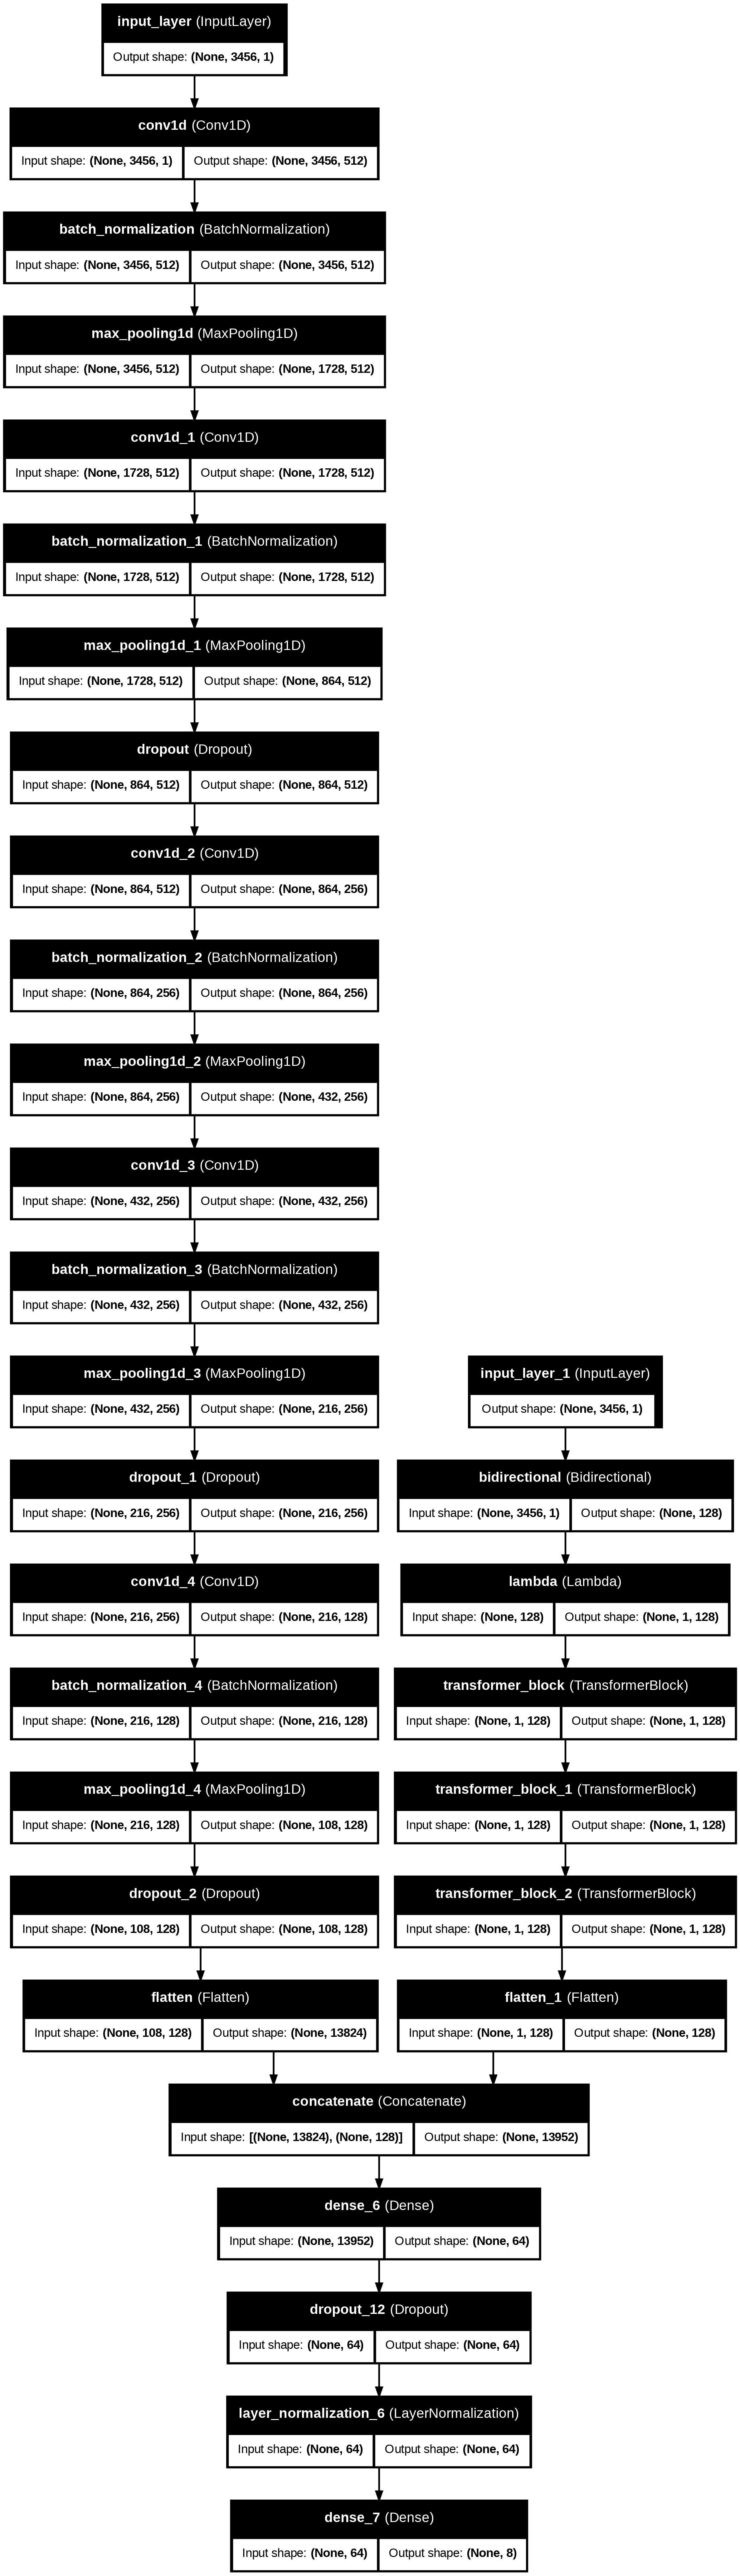

In [41]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Model Evaluation

In [42]:
y_pred = model.predict([x_testcnn, x_testcnn])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

classes = ravdess_df.emotion.unique()

62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step


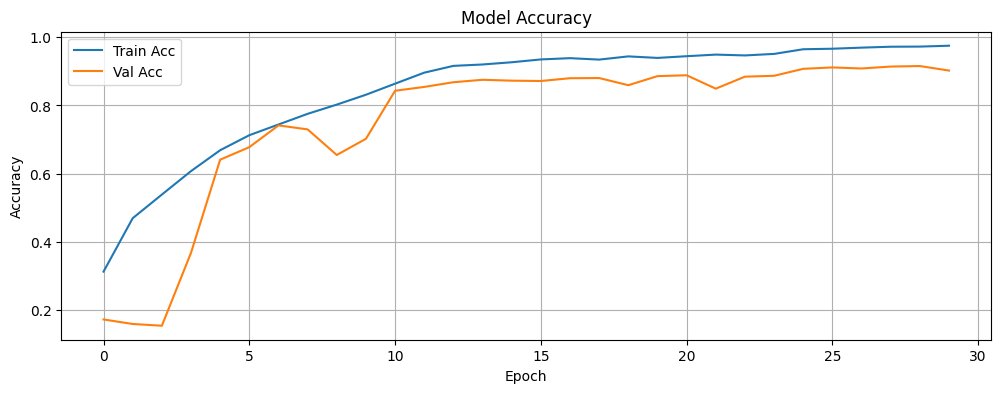

In [52]:
# Accuracy
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


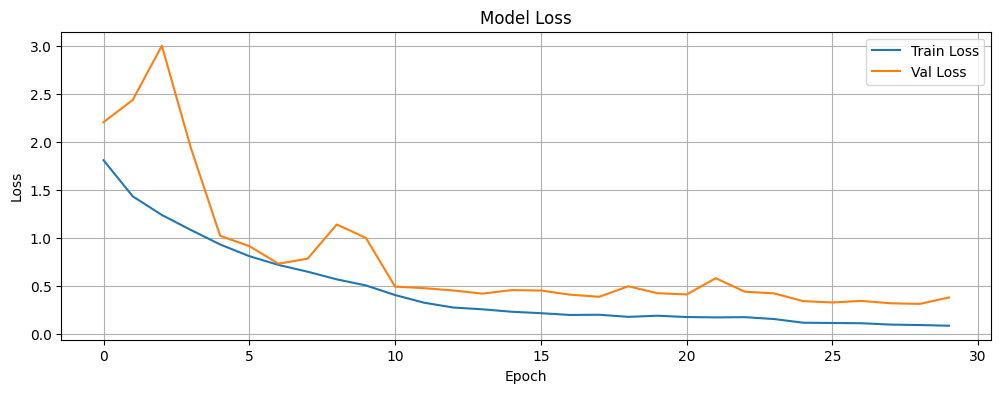

In [53]:
# Loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

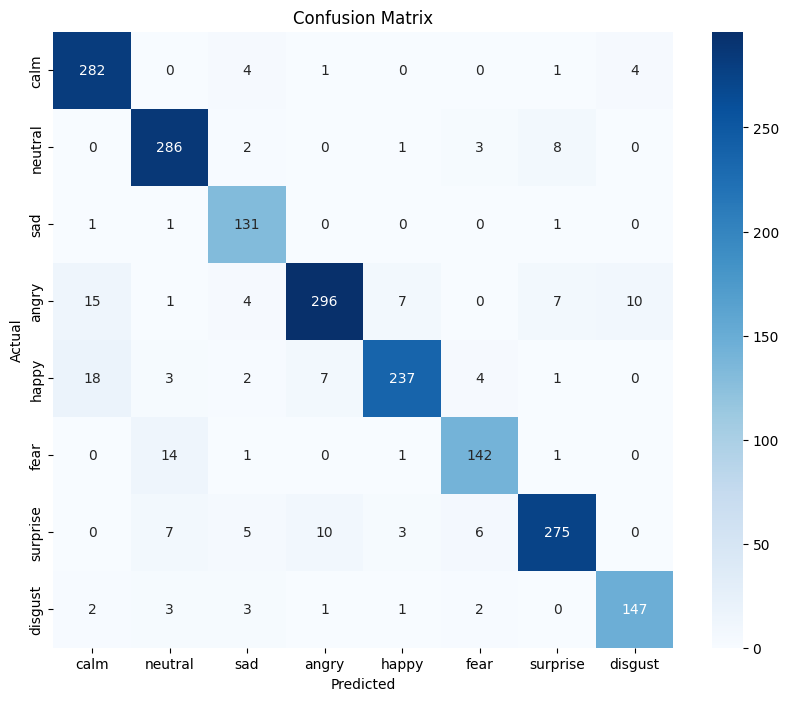

In [54]:
# Function to Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, classes)

In [55]:
# Function to print classification report with metrics
def classification_report_with_metrics(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

# Print the classification report with metrics
classification_report_with_metrics(y_true_classes, y_pred_classes, classes)

precision    recall  f1-score      support
calm           0.886792  0.965753  0.924590   292.000000
neutral        0.907937  0.953333  0.930081   300.000000
sad            0.861842  0.977612  0.916084   134.000000
angry          0.939683  0.870588  0.903817   340.000000
happy          0.948000  0.871324  0.908046   272.000000
fear           0.904459  0.893082  0.898734   159.000000
surprise       0.935374  0.898693  0.916667   306.000000
disgust        0.913043  0.924528  0.918750   159.000000
accuracy       0.915392  0.915392  0.915392     0.915392
macro avg      0.912141  0.919364  0.914596  1962.000000
weighted avg   0.917108  0.915392  0.915151  1962.000000

In [47]:
# Function to print overall precision, recall, and F1 score
def overall_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Overall Precision: {precision:.2f}")
    print(f"Overall Recall: {recall:.2f}")
    print(f"Overall F1 Score: {f1:.2f}")

# Print overall precision, recall, and F1 score
overall_metrics(y_true_classes, y_pred_classes)

Overall Precision: 0.92
Overall Recall: 0.92
Overall F1 Score: 0.92


In [57]:
# Save in modern .keras format (TensorFlow 2.11+)
model.save("Emotion_Model1.keras")
# Save in legacy HDF5 .h5 format (useful for compatibility)
model.save("Emotion_Model2.h5")
# Optional just weights if needed
model.save_weights("Emotion_Model.weights.h5")